In [72]:
import numpy as np
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import comms
import ipywidgets as ipw

import keras 
from keras.models import Sequential 
from keras.layers import Dense, Dropout, Flatten, Input
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import SGD
from keras.regularizers import l2
from keras.preprocessing.image import ImageDataGenerator

## Load the data 

In [2]:
data_train = comms.load_data("train.json/data/processed/train.json")

## Design a model in Keras

In [116]:
model = Sequential()
# Block 1
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv1', input_shape = (75, 75, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same', name='block1_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block1_pool'))

# Block 2
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv1'))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same', name='block2_conv2'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block2_pool'))

# Block 3
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv1'))
model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv2'))
# model.add(Conv2D(256, (3, 3), activation='relu', padding='same', name='block3_conv3'))
model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block3_pool'))

# Block 4
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv1'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv2'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block4_conv3'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block4_pool'))

# Block 5
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv1'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv2'))
# model.add(Conv2D(512, (3, 3), activation='relu', padding='same', name='block5_conv3'))
# model.add(MaxPooling2D((2, 2), strides=(2, 2), name='block5_pool'))

model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy')

## Train the model 

In [117]:
data_train = data_train[data_train.inc_angle != "na"]

In [118]:
sin_inc_angle = np.sin(np.deg2rad(data_train.inc_angle.astype(float)))
cos_inc_angle = np.cos(np.deg2rad(data_train.inc_angle.astype(float)))
tan_inc_angle = np.tan(np.deg2rad(data_train.inc_angle.astype(float)))

In [119]:
img_train, ang_train = comms.get_img_and_angle(data_train)
is_ice_train = comms.get_is_iceberg(data_train)

In [120]:
datagen = ImageDataGenerator(
        #rotation_range=40,
        #width_shift_range=0.2,
        #height_shift_range=0.2,
        #shear_range=0.2,
        #zoom_range=0.2,
        vertical_flip = True,
        horizontal_flip=True,
        fill_mode='nearest')

In [121]:
board = keras.callbacks.TensorBoard(write_images=True)

In [122]:
train_generator = datagen.flow(x = img_train, y=is_ice_train)

C:\WinPython-64bit-3.6.3.0Qt5\python-3.6.3.amd64\lib\site-packages\keras\preprocessing\image.py:787: UserWarning: NumpyArrayIterator is set to use the data format convention "channels_last" (channels on axis 3), i.e. expected either 1, 3 or 4 channels on axis 3. However, it was passed an array with shape (1471, 75, 75, 2) (2 channels).
  ' (' + str(self.x.shape[channels_axis]) + ' channels).')


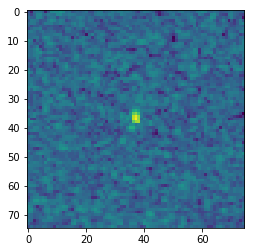

In [123]:
plt.imshow(train_generator.next()[0][0, :, :, 0])
plt.show()

In [124]:
model.fit_generator(train_generator, steps_per_epoch=100, epochs = 2)

Epoch 1/2
  3/100 [..............................] - ETA: 586s - loss: 5.9814

KeyboardInterrupt: 

## Make predictions for the test data 

In [54]:
data_test = comms.load_data("test.json/data/processed/test.json")

In [55]:
img_test, ang_test = comms.get_img_and_angle(data_test)

In [56]:
is_ice_test = model.predict(img_test)

In [57]:
id_test = np.array(data_test.id)

In [58]:
res = pd.DataFrame({"id" : id_test.flatten(), "is_iceberg" : is_ice_test.flatten()})
res.to_csv("result.csv", sep=",", index=False)